## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import tensorflow.keras as keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
LN_EXP = [1e-2, 1e-4, 1e-8]

In [7]:
results = {}

for regulizer_ratio in LN_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

for regulizer_ratio in LN_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [======

50000/50000 [==============================] - 3s 67us/sample - loss: 2.4626 - accuracy: 0.0999 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 70us/sample - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 4s 71us/sample - loss: 2.4626 - accuracy: 0.0969 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________

50000/50000 [==============================] - 4s 74us/sample - loss: 2.8272 - accuracy: 0.6187 - val_loss: 3.2148 - val_accuracy: 0.4943
Epoch 46/50
50000/50000 [==============================] - 4s 76us/sample - loss: 2.7821 - accuracy: 0.6244 - val_loss: 3.0363 - val_accuracy: 0.5291
Epoch 47/50
50000/50000 [==============================] - 4s 82us/sample - loss: 2.7422 - accuracy: 0.6262 - val_loss: 3.0049 - val_accuracy: 0.5320
Epoch 48/50
50000/50000 [==============================] - 4s 85us/sample - loss: 2.7109 - accuracy: 0.6246 - val_loss: 2.9859 - val_accuracy: 0.5260
Epoch 49/50
50000/50000 [==============================] - 4s 78us/sample - loss: 2.6719 - accuracy: 0.6280 - val_loss: 3.0857 - val_accuracy: 0.4963
Epoch 50/50
50000/50000 [==============================] - 4s 72us/sample - loss: 2.6361 - accuracy: 0.6299 - val_loss: 2.9392 - val_accuracy: 0.5229
Experiment with Regulizer = 0.000000
Model: "model"
____________________________________________________________

50000/50000 [==============================] - 4s 73us/sample - loss: 0.9684 - accuracy: 0.6598 - val_loss: 1.4331 - val_accuracy: 0.5112
Epoch 43/50
50000/50000 [==============================] - 4s 81us/sample - loss: 0.9510 - accuracy: 0.6659 - val_loss: 1.3684 - val_accuracy: 0.5311
Epoch 44/50
50000/50000 [==============================] - 5s 90us/sample - loss: 0.9419 - accuracy: 0.6698 - val_loss: 1.3844 - val_accuracy: 0.5255
Epoch 45/50
50000/50000 [==============================] - 4s 84us/sample - loss: 0.9316 - accuracy: 0.6737 - val_loss: 1.3552 - val_accuracy: 0.5339
Epoch 46/50
50000/50000 [==============================] - 4s 70us/sample - loss: 0.9209 - accuracy: 0.6781 - val_loss: 1.3714 - val_accuracy: 0.5274
Epoch 47/50
50000/50000 [==============================] - 3s 68us/sample - loss: 0.9102 - accuracy: 0.6802 - val_loss: 1.3879 - val_accuracy: 0.5275
Epoch 48/50
50000/50000 [==============================] - 3s 70us/sample - loss: 0.8952 - accuracy: 0.6876 - va

50000/50000 [==============================] - 3s 69us/sample - loss: 1.6682 - accuracy: 0.5089 - val_loss: 1.7174 - val_accuracy: 0.4837
Epoch 40/50
50000/50000 [==============================] - 4s 75us/sample - loss: 1.6613 - accuracy: 0.5095 - val_loss: 1.7000 - val_accuracy: 0.4929
Epoch 41/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.6535 - accuracy: 0.5118 - val_loss: 1.7340 - val_accuracy: 0.4763
Epoch 42/50
50000/50000 [==============================] - 4s 81us/sample - loss: 1.6476 - accuracy: 0.5124 - val_loss: 1.7592 - val_accuracy: 0.4709
Epoch 43/50
50000/50000 [==============================] - 4s 76us/sample - loss: 1.6418 - accuracy: 0.5129 - val_loss: 1.6926 - val_accuracy: 0.4904
Epoch 44/50
50000/50000 [==============================] - 4s 81us/sample - loss: 1.6364 - accuracy: 0.5165 - val_loss: 1.7110 - val_accuracy: 0.4858
Epoch 45/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.6323 - accuracy: 0.5157 - va

50000/50000 [==============================] - 4s 77us/sample - loss: 1.1888 - accuracy: 0.6307 - val_loss: 1.5426 - val_accuracy: 0.5132
Epoch 37/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.1739 - accuracy: 0.6364 - val_loss: 1.4781 - val_accuracy: 0.5349
Epoch 38/50
50000/50000 [==============================] - 4s 74us/sample - loss: 1.1608 - accuracy: 0.6416 - val_loss: 1.5058 - val_accuracy: 0.5287
Epoch 39/50
50000/50000 [==============================] - 4s 75us/sample - loss: 1.1475 - accuracy: 0.6466 - val_loss: 1.5064 - val_accuracy: 0.5299
Epoch 40/50
50000/50000 [==============================] - 4s 74us/sample - loss: 1.1357 - accuracy: 0.6508 - val_loss: 1.5213 - val_accuracy: 0.5245
Epoch 41/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.1260 - accuracy: 0.6541 - val_loss: 1.5245 - val_accuracy: 0.5195
Epoch 42/50
50000/50000 [==============================] - 3s 69us/sample - loss: 1.1120 - accuracy: 0.6571 - va

50000/50000 [==============================] - 4s 72us/sample - loss: 1.0754 - accuracy: 0.6234 - val_loss: 1.3511 - val_accuracy: 0.5217
Epoch 34/50
50000/50000 [==============================] - 4s 71us/sample - loss: 1.0648 - accuracy: 0.6240 - val_loss: 1.4407 - val_accuracy: 0.5030
Epoch 35/50
50000/50000 [==============================] - 3s 70us/sample - loss: 1.0529 - accuracy: 0.6305 - val_loss: 1.4655 - val_accuracy: 0.5031
Epoch 36/50
50000/50000 [==============================] - 4s 73us/sample - loss: 1.0384 - accuracy: 0.6349 - val_loss: 1.3953 - val_accuracy: 0.5154
Epoch 37/50
50000/50000 [==============================] - 4s 71us/sample - loss: 1.0266 - accuracy: 0.6404 - val_loss: 1.3570 - val_accuracy: 0.5298
Epoch 38/50
50000/50000 [==============================] - 4s 72us/sample - loss: 1.0156 - accuracy: 0.6433 - val_loss: 1.3565 - val_accuracy: 0.5345
Epoch 39/50
50000/50000 [==============================] - 4s 75us/sample - loss: 1.0018 - accuracy: 0.6469 - va

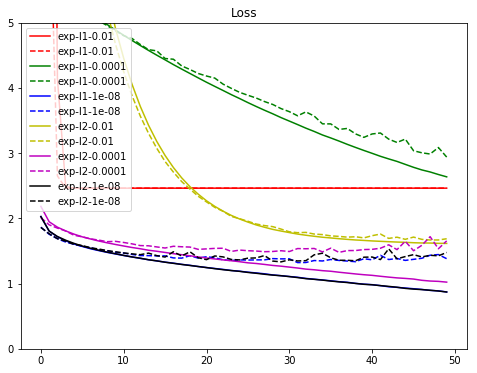

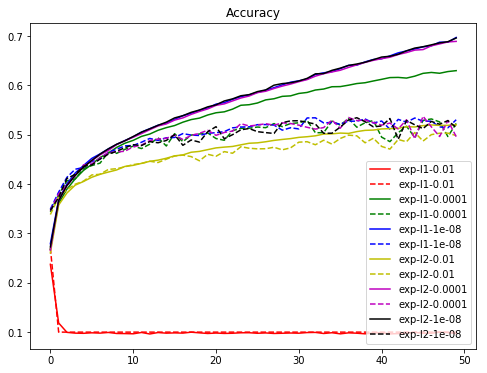

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()